# Transfer Learning

Na maioria das vezes, você não vai querer treinar toda uma rede convolucional. O treinamento moderno do ConvNets em grandes datasets como o ImageNet leva semanas em várias GPUs.
> Em vez disso, a maioria das pessoas usa uma rede pré-treinada como um extrator de features fixo ou como uma rede inicial para ser treinada.

Neste notebook, você usará a [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) treinada no [dataset ImageNet](http://www.image-net.org/) como um extrator de features. Abaixo está um diagrama da arquitetura VGGNet, com uma série de camadas convolucionais e de maxpooling, e depois três camadas lineares no final, que classificam as 1000 classes encontradas no dataset ImageNet.

<img src="notebook_ims/vgg_16_architecture.png" width=700px>

A VGGNet é ótima porque é simples e tem ótimo desempenho, ficando em segundo lugar na competição ImageNet. A idéia aqui é que mantenhamos todas as camadas convolucionais, mas que a gente **substitua a camada linear final** por nosso próprio classificador. Dessa forma, podemos usar a VGGNet como um extrator de features fixo para nossas imagens e treinar facilmente um classificador simples.
* Use todos, exceto a última camada linear, como um extrator de features fixo.
* Defina uma nova camada final de classificação e aplique-a em uma tarefa de nossa escolha!

Você pode ler mais sobre transfer learning nas [notas de aula do curso do CS231n Stanford](http://cs231n.github.io/transfer-learning/).

---

## Flores

Aqui vamos usar a VGGNet para classificar imagens de flores. Começaremos, como sempre, importando nossos recursos habituais e verificando se podemos treinar nosso modelo em GPU.

### Download dos dados

Faça o download dos dados das flores [neste link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/Setembro/5baa60a0_flower-photos/flower-photos.zip), salve-os no diretório raíz deste notebook e extraia o arquivo zip para obter o diretório `flower_photos/`. **Verifique se o diretório tem esse nome exato para acessar os dados: flower_photos**.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Checando se CUDA está disponível
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


## Load and Transform our Data

Iremos utilizar a classe [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) do PyTorch que facilita a carga dos dados a partir do disco rígido. Por exemplo, as imagens de treinamento estão ordenadas em um caminho que possui o seguinte padrão:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Nesse caso, o diretório raíz para treinamento é `flower_photos/train/` e as classes são os nomes dos tipos das flores.

In [4]:
# definindo diretórios de treinamento e teste
colab = '/content/drive/My Drive/Colab Notebooks/transflearn/flower_photos'
data_dir = 'flower_photos/'

train_dir = os.path.join(colab, 'train2/')
test_dir = os.path.join(colab, 'test/')

# classes são pastas em cada diretório com esses nomes
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Transformando os Dados

Ao realizar transfer learning, precisamos modelar os dados de entrada de tal forma que possuam o mesmo formato que a rede pré-treinada espera receber. A VGG16 espera receber, como entrada, imagens quadradas de dimensões 224, então precisamos reformatar as imagens de flores para este formato.

In [5]:
# carregando e transformando dados usando ImageFolder

# VGG-16 recebe imagens de entrada 224x224, então vamos redimensioná-las
#data_transform = transforms.Compose([transforms.RandomResizedCrop(56),
#                                      transforms.ToTensor()])

# ALTERAR DE VOLTA PARA 224x224
#data_transform = transforms.Compose([transforms.RandomCrop(112, padding=3, padding_mode='reflect'),
#                                     transforms.ToTensor()])

data_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.Pad(3, padding_mode='reflect'),
                                     transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# vamos ver algumas estatísticas das imagens
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  2996
Num test images:  540


### DataLoaders e Data Visualization

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 20
num_workers=1
# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

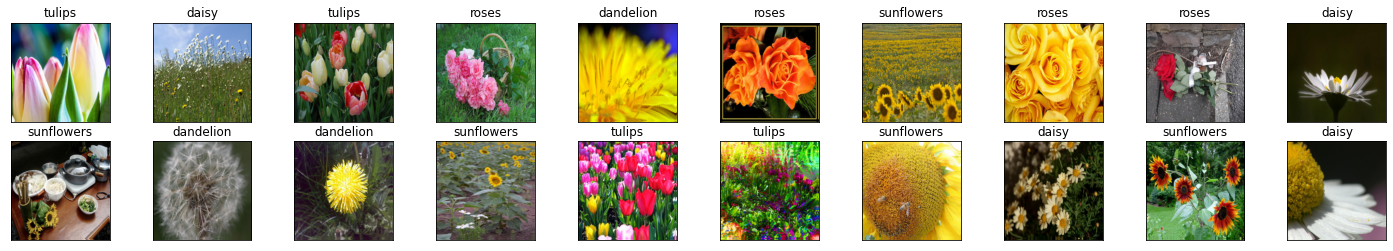

In [7]:
# Visualizando alguns dados

# Obtendo um batch do conjunto de treinamento
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convertemos a imagem para numpy para podermos visualizá-la

# Visualizando as imagens do batch junto com suas respectivas labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

---
## Definindo o Modelo

Para definir o modelo, vamos seguir os seguintes passos:
1. Carregar o modelo VGG16 pré-treinado
2. "Congelar" todos os parâmetros, para que a extração de características fique fixa
3. Remover a última camada
4. Substituir a última camada por um classificador linear novo

**Congelar simplesmente significa que os parâmetros no modelo pré-treinado *não* serão alterados durante o treinamento**

In [8]:
# Carregando o modelo a partir do PyTorch
vgg16 = models.vgg16(pretrained=True)

# Vamos ver a estrutura do modelo
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 


4096
1000


In [10]:
# Congelando o treinamento para todas as camadas de "features"
for param in vgg16.features.parameters():
    param.requires_grad = False
    
# Congelando o treinamento para todas as camadas "classifier"
#for param in vgg16.classifier.parameters():
#    param.requires_grad = False
    

---
### Camada final do classificador

Depois de ter o extrator de features pré-treinado, basta modificar e/ou adicionar às camadas classificadoras finais lineares. Nesse caso, sugerimos que você altere a última camada do grupo de classificadores da vgg.
> Essa camada deve ver como entrada o número de features produzidas pela parte da rede que você não está alterando e produzir um número apropriado de saídas para a tarefa de classificação de flores.

Você pode acessar qualquer camada em uma rede pré-treinada por nome e número (às vezes), ou seja, `vgg16.classifier[6]` é a sétima camada em um grupo de camadas chamado "classificador".

#### TODO: Substitua a última camada linear por uma que produza o número apropriado de classes desejadas.

In [11]:
import torch.nn as nn ## TODO: adicionar uma última camada linear que mapeia n_inputs -> 5 classes de flores
## novas camadas automaticamente possuem requires_grad = True

linear_layer = nn.Linear(vgg16.classifier[6].in_features, len(classes))

vgg16.classifier[6] = linear_layer

# após completar o modelo, se houver GPU disponível, mova-o para a GPU
if train_on_gpu:
    vgg16.cuda()


### Defina a [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) e o [Optimizer](http://pytorch.org/docs/stable/optim.html)

Agora, vamos utilizar a cross-entropy loss e o gradiente descendente estocástico com um learning rate baixo. Note que o otimizador aceita, como entrada, _apenas_ os parâmetros treináveis `vgg.classifier.parameters()`.

In [12]:
import torch.optim as optim

# Especificando a função de loss (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Especificando o otimizador e learning rate
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.0001, momentum=0.9)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [13]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [14]:
es = EarlyStopping(patience=5)

---
## Treinamento

Vamos treinar a rede.
> **Exercício:** Aqui, vou deixar por sua conta a implementação do código de treinamento. Basicamente, o código aqui não difere muito do loop de treinamento que sempre é feito com o PyTorch. Note que não estamos utilizando conjunto de validação aqui. Opcionalmente, você pode criar o conjunto de validação e realizar o treinamento como deveria ser (recomendo que você faça assim). **O conjunto de validação deve ser extraído do conjunto de treinamento, não de teste**. Garanta que os conjuntos estejam sempre balanceados. Não se esqueça de plotar as linhas de loss de treino e validação e de implementar o early stopping. Imprima sua acurácia final, matriz de confusão e suas métricas. Teste o seu loop com apenas duas épocas, mas quando estiver seguro que o código está correto, aumente as épocas até que o treinamento seja sempre interrompido pelo early stopping e não pelo fim das épocas.

In [16]:
import gc 
# Número de épocas
n_epochs = 200

## TODO: complete os loops de treinamento das épocas com batch
## Esses loops devem atualizar os pesos do classificador do modelo
## e rastrear o loss no decorrer do tempo.
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    vgg16.train()
    for batch, (data, target) in enumerate(train_loader):
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        
        output = vgg16(data)
        
        loss = criterion(output, target)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += float(loss.item())#*data.size(0)
        
    #metric = eval(vgg16, valid_loader)  # evalution on dev set (i.e., holdout from training)
    
    if es.step(loss):
        break  # early stop criterion is met, we can stop now
            
    vgg16.eval()
    for batch, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = vgg16(data)

        loss = criterion(output, target)

        valid_loss += float(loss.item())#*data.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    if es.step(loss):
        break  # early stop criterion is met, we can stop now
    
    # Verifica e modifica o learning rate (lr)
    scheduler.step(loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
        print('Validation loss for epoch {} decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
            epoch,
            valid_loss_min,
            valid_loss))
        torch.save(vgg16.state_dict(), 'vgg16')
        valid_loss_min = valid_loss
    
    
    
    gc.collect() 
    torch.cuda.empty_cache()

Epoch: 1 	Training Loss: 0.037623 	Validation Loss: 0.032515
Validation loss for epoch 1 decreased (inf --> 0.032515). Saving model ...
Epoch: 2 	Training Loss: 0.030533 	Validation Loss: 0.028230
Validation loss for epoch 2 decreased (0.032515 --> 0.028230). Saving model ...
Epoch: 3 	Training Loss: 0.027204 	Validation Loss: 0.025512
Validation loss for epoch 3 decreased (0.028230 --> 0.025512). Saving model ...
Epoch: 4 	Training Loss: 0.024955 	Validation Loss: 0.023796
Validation loss for epoch 4 decreased (0.025512 --> 0.023796). Saving model ...
Epoch: 5 	Training Loss: 0.023154 	Validation Loss: 0.022740
Validation loss for epoch 5 decreased (0.023796 --> 0.022740). Saving model ...
Epoch: 6 	Training Loss: 0.021725 	Validation Loss: 0.021775
Validation loss for epoch 6 decreased (0.022740 --> 0.021775). Saving model ...
Epoch: 7 	Training Loss: 0.020264 	Validation Loss: 0.020838
Validation loss for epoch 7 decreased (0.021775 --> 0.020838). Saving model ...
Epoch: 8 	Training

---
## Testando

Abaixo, vamos checar a acurácia para cada classe de flor. Adapte esse código para obter as métricas pedidas no exercício.

In [18]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.488893

Test Accuracy of daisy: 88% (81/92)
Test Accuracy of dandelion: 95% (126/132)
Test Accuracy of roses: 72% (66/91)
Test Accuracy of sunflowers: 85% (86/101)
Test Accuracy of tulips: 72% (90/124)

Test Accuracy (Overall): 83% (449/540)


### Visualizando Amostras dos Resultados de Teste

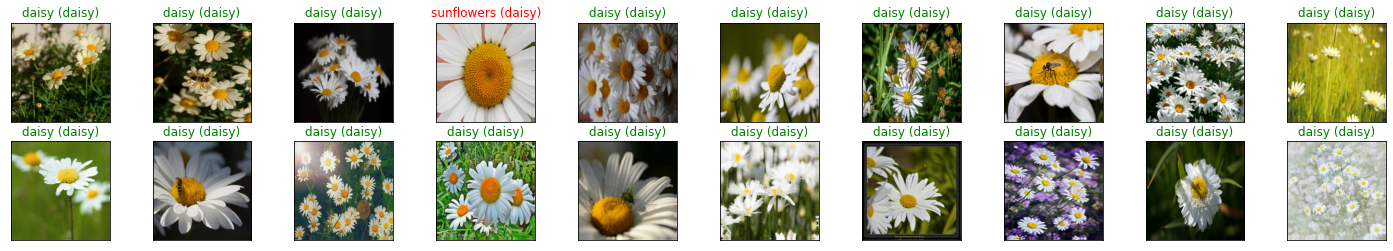

In [19]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    img = np.squeeze(images[idx].numpy()) if not train_on_gpu else np.squeeze(images[idx].cpu().numpy())
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## DESAFIO

Pesquise sobre diferentes arquiteturas de redes e proponha um método de classificação de flores que seja o melhor da turma (tendo a métrica de acurácia como referência). **Você precisa utilizar necessariamente este dataset**.

Aqui, vale tudo! Treinar redes do zero, utilizar transfer learning, utilizar outros métodos etc. Utilize tudo ao seu alcance para obter a melhor acurácia sobre o conjunto de testes deste notebook.

Não se esqueça também de imprimir, além da acurácia, todas as demais informações que foram pedidas no exercício deste notebook. Aqui, é obrigatório o uso do conjunto de validação no processo de treinamento. **O conjunto de validação deve ser extraído do conjunto de treinamento, não de teste**. Garanta que os conjuntos estejam sempre balanceados.

**O grupo que conseguir a maior acurácia receberá um ponto extra neste exercício**.

Este notebook foi adaptado do curso Deep Learning Nanodegree da Udacity, cujo repositório está disponível [aqui](https://github.com/udacity/deep-learning-v2-pytorch).